<a href="https://colab.research.google.com/github/youngchurl/Going_Deeper/blob/main/%5BG_02%5D_ResNet_Ablation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going Deeper 
## [G-02] ResNet Ablation Study

> ## 목차
---

### 1. 프로젝트 개요
    1 .1 요약
    1 .2 루브릭 평가 기준
### 2. 프로젝트
    2 .1 Cats and Dogs Data set 불러오기
    2 .2 ResNet 기본 블록 구성하기
    2 .2 ResNet-34, ResNet-50 Complete Model
    2 .3 일반 네트워크(plain network) 만들기
    2 .4 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
### 3. 결론

> ## 1. 프로젝트 개요
---

> ### 1.1 요약

Ablation Study를 고잉디퍼 1 에서 봤던 ResNet을 통해서 공부해보는건데  
이번 노드에 주 포인트는   
- 중복되는 특징을 갖고 모델의 블록을 잘 만들어 낼 수 있는지  
- 이를 통해서 모델을 제작하고 Plain 모델과 논문 속 모델을 비교해서 효용성 검증이다.

> ### 1.2 루브릭 평가 기준

|평가문항 | 상세기준|
|:---------|:---------|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?| cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?| ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

> ## 2. 프로젝트
---

> ### 2. 1 ResNet 기본 블록 구성하기

In [2]:
# TensorFlow and tf.keras
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math
 
import random
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_path = '/content/drive/MyDrive/Colab Notebooks/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/test'

In [5]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 64
image_height = 64
image_size = (image_width, image_height)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        directory = '/content/drive/MyDrive/Colab Notebooks/cat&dog',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        directory = '/content/drive/MyDrive/Colab Notebooks/cat&dog',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

Found 37500 images belonging to 2 classes.
Found 37500 images belonging to 2 classes.


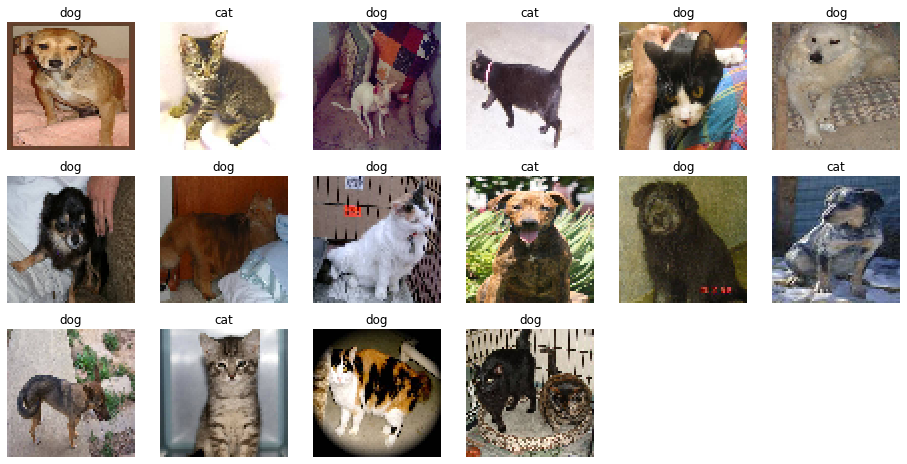

In [6]:
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

### ResNet 34 Block & ResNet 50 Block

In [7]:
# function for building ResNet 34 Block & 50 Block
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = layers.BatchNormalization()(x)
            x = layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

def build_resnet(input_shape=(64,64,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=2,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 2
        
    input_layer = layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = layers.AveragePooling2D(padding = 'same')(output)
    output = layers.Flatten(name='flatten')(output)
    output = layers.Dense(512, activation='relu', name='fc1')(output)    
    output = layers.Dense(num_classes-1, activation='sigmoid', name='predictions')(output)
    
    model = Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

### ResNet 50 Block

In [8]:
# function for building ResNet 50 Block

K = 2 # Class 개수 
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer2(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   

def conv2_layer2(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x

def conv3_layer2(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x

def conv4_layer2(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x

def conv5_layer2(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x


VGG 를 참조해서 모델링을 하는데, ResNet의 경우엔 각 블럭마다 Max Pooling이 일어나는게 아니기 때문에 주석 처리했다.

> ### 2. 2 ResNet-34, ResNet-50 Complete Model

### ResNet 34 Model


In [9]:
# ResNet 34
resnet_34 = build_resnet(is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   832         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

### ResNet 50 Model

In [10]:
# ResNet 50
resnet_50 = build_resnet(is_50 = True)
resnet_50.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 64)   832         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 32, 32, 64)  256         ['conv2d_4[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 64)  0           ['batch_normalization_17[0]

> ### 2. 3 일반 네트워크(plain network) 만들기

In [11]:
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)


In [12]:
plain_resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 64)   832         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 32, 32, 64)  256         ['conv2d_8[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)  0           ['batch_normalization_34[0]

In [13]:
plain_resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 64)   832         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_51 (BatchN  (None, 32, 32, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 64)  0           ['batch_normalization_51[0]

> ### 2. 4 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [14]:
resnet_34.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy'],
)

# resnet_34.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
#     metrics=['accuracy'],
# )

BATCH_SIZE, EPOCH= 16, 30

# resnet_34.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# history1 = resnet_34.fit_generator(
#     train_generator, 
#     epochs=EPOCH,
#     steps_per_epoch=train_generator.samples / BATCH_SIZE, 
#     validation_data=validation_generator,
#     validation_steps=train_generator.samples / BATCH_SIZE,
# )

histoty_34 = resnet_34.fit(
    train_generator,
    steps_per_epoch=int(BATCH_SIZE),
    validation_steps=int(BATCH_SIZE),
    epochs=EPOCH,
    validation_data=validation_generator,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
16/16 [==============================] - 229s 15s/step - loss: 7.2206 - accuracy: 0.5117 - val_loss: 39.7241 - val_accuracy: 0.6797
Epoch 2/30
16/16 [==============================] - 77s 5s/step - loss: 2.2332 - accuracy: 0.5391 - val_loss: 1.0384 - val_accuracy: 0.6914
Epoch 3/30
16/16 [==============================] - 80s 5s/step - loss: 1.9880 - accuracy: 0.5117 - val_loss: 0.7450 - val_accuracy: 0.3203
Epoch 4/30
16/16 [==============================] - 76s 5s/step - loss: 0.9939 - accuracy: 0.6602 - val_loss: 0.6342 - val_accuracy: 0.6641
Epoch 5/30
16/16 [==============================] - 70s 5s/step - loss: 1.7252 - accuracy: 0.6367 - val_loss: 0.6767 - val_accuracy: 0.6250
Epoch 6/30
16/16 [==============================] - 67s 4s/step - loss: 1.2474 - accuracy: 0.5234 - val_loss: 0.6580 - val_accuracy: 0.6289
Epoch 7/30
16/16 [==============================] - 67s 4s/step - loss: 1.0927 - accuracy: 0.5781 - val_loss: 0.8394 - val_accuracy: 0.3438
Epoch 8/30
16/16 

In [15]:
# resnet 50
resnet_50.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy'],
)

BATCH_SIZE, EPOCH= 16, 30

histoty_50 = resnet_50.fit(
    train_generator,
    steps_per_epoch=int(BATCH_SIZE),
    validation_steps=int(BATCH_SIZE),
    epochs=EPOCH,
    validation_data=validation_generator,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
16/16 [==============================] - 41s 3s/step - loss: 7.8127 - accuracy: 0.4922 - val_loss: 150.8076 - val_accuracy: 0.3203
Epoch 2/30
16/16 [==============================] - 37s 2s/step - loss: 1.8704 - accuracy: 0.5234 - val_loss: 30.4241 - val_accuracy: 0.6953
Epoch 3/30
16/16 [==============================] - 38s 2s/step - loss: 1.4185 - accuracy: 0.5547 - val_loss: 5.1079 - val_accuracy: 0.6484
Epoch 4/30
16/16 [==============================] - 33s 2s/step - loss: 1.2876 - accuracy: 0.5820 - val_loss: 0.8674 - val_accuracy: 0.5859
Epoch 5/30
16/16 [==============================] - 33s 2s/step - loss: 1.5308 - accuracy: 0.6016 - val_loss: 1.3771 - val_accuracy: 0.3477
Epoch 6/30
16/16 [==============================] - 40s 3s/step - loss: 1.5043 - accuracy: 0.5391 - val_loss: 0.9024 - val_accuracy: 0.7305
Epoch 7/30
16/16 [==============================] - 31s 2s/step - loss: 1.7603 - accuracy: 0.6211 - val_loss: 1.2677 - val_accuracy: 0.5781
Epoch 8/30
16/16 

In [16]:
# plain 34
plain_resnet_34.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy'],
)

BATCH_SIZE, EPOCH= 16, 30

histoty_pl_34 = plain_resnet_34.fit(
    train_generator,
    steps_per_epoch=int(BATCH_SIZE),
    validation_steps=int(BATCH_SIZE),
    epochs=EPOCH,
    validation_data=validation_generator,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
16/16 [==============================] - 26s 2s/step - loss: 6.8681 - accuracy: 0.4570 - val_loss: 8.5338 - val_accuracy: 0.3672
Epoch 2/30
16/16 [==============================] - 21s 1s/step - loss: 1.8109 - accuracy: 0.6094 - val_loss: 5.2195 - val_accuracy: 0.6758
Epoch 3/30
16/16 [==============================] - 20s 1s/step - loss: 1.3111 - accuracy: 0.5234 - val_loss: 1.9777 - val_accuracy: 0.7109
Epoch 4/30
16/16 [==============================] - 20s 1s/step - loss: 1.4966 - accuracy: 0.5859 - val_loss: 8.5269 - val_accuracy: 0.3555
Epoch 5/30
16/16 [==============================] - 16s 1s/step - loss: 2.2644 - accuracy: 0.5352 - val_loss: 0.7907 - val_accuracy: 0.6523
Epoch 6/30
16/16 [==============================] - 24s 2s/step - loss: 1.7876 - accuracy: 0.5430 - val_loss: 3.5171 - val_accuracy: 0.6797
Epoch 7/30
16/16 [==============================] - 21s 1s/step - loss: 1.5425 - accuracy: 0.5703 - val_loss: 0.8584 - val_accuracy: 0.3555
Epoch 8/30
16/16 [==

In [17]:
# plain 50
plain_resnet_50.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy'],
)

BATCH_SIZE, EPOCH= 16, 30

histoty_pl_50 = plain_resnet_50.fit(
    train_generator,
    steps_per_epoch=int(BATCH_SIZE),
    validation_steps=int(BATCH_SIZE),
    epochs=EPOCH,
    validation_data=validation_generator,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
16/16 [==============================] - 15s 811ms/step - loss: 7.2222 - accuracy: 0.5039 - val_loss: 5.1667 - val_accuracy: 0.6680
Epoch 2/30
16/16 [==============================] - 10s 634ms/step - loss: 1.9357 - accuracy: 0.4883 - val_loss: 1.8947 - val_accuracy: 0.3125
Epoch 3/30
16/16 [==============================] - 15s 916ms/step - loss: 1.4757 - accuracy: 0.6016 - val_loss: 0.6565 - val_accuracy: 0.7031
Epoch 4/30
16/16 [==============================] - 12s 776ms/step - loss: 1.8232 - accuracy: 0.5820 - val_loss: 0.8494 - val_accuracy: 0.2852
Epoch 5/30
16/16 [==============================] - 10s 674ms/step - loss: 2.5453 - accuracy: 0.5195 - val_loss: 0.6563 - val_accuracy: 0.6445
Epoch 6/30
16/16 [==============================] - 9s 612ms/step - loss: 1.7819 - accuracy: 0.6055 - val_loss: 0.6728 - val_accuracy: 0.5664
Epoch 7/30
16/16 [==============================] - 13s 871ms/step - loss: 1.8087 - accuracy: 0.4727 - val_loss: 0.7294 - val_accuracy: 0.4258


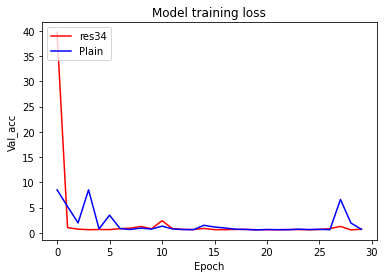

In [18]:
import matplotlib.pyplot as plt

plt.plot(histoty_34.history['val_loss'], 'r')
plt.plot(histoty_pl_34.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Val_acc')
plt.xlabel('Epoch')
plt.legend(['res34', 'Plain'], loc='upper left')
plt.show()

초기에 val_loss가 너무 커서 값을 비교하기 어려우기 때문에 범위를 지정해 새로 비교한다

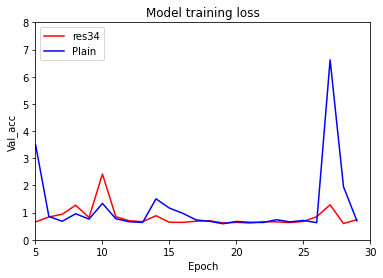

In [22]:
import matplotlib.pyplot as plt

plt.plot(histoty_34.history['val_loss'], 'r')
plt.plot(histoty_pl_34.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Val_acc')
plt.xlim(5,30)
plt.ylim(0,8)
plt.xlabel('Epoch')
plt.legend(['res34', 'Plain'], loc='upper left')
plt.show()

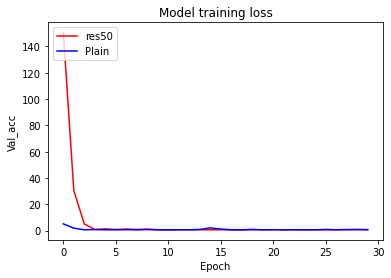

In [24]:
import matplotlib.pyplot as plt

plt.plot(histoty_50.history['val_loss'], 'r')
plt.plot(histoty_pl_50.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Val_acc')
plt.xlabel('Epoch')
plt.legend(['res50', 'Plain'], loc='upper left')
plt.show()

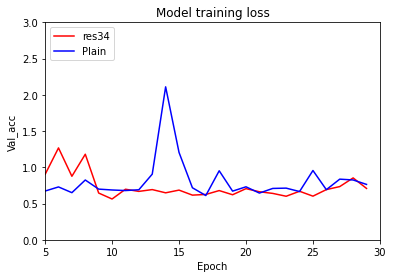

In [25]:
import matplotlib.pyplot as plt

plt.plot(histoty_50.history['val_loss'], 'r')
plt.plot(histoty_pl_50.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Val_acc')
plt.xlim(5,30)
plt.ylim(0,3)
plt.xlabel('Epoch')
plt.legend(['res34', 'Plain'], loc='upper left')
plt.show()

> ## 결론
---

ResNet이 Plain 모델의 경우보다 val loss 가 튀는 경우도 없고 안정적임을 확인할 수 있다.
때문에 Short cut을 통해 인풋값을 계속해서 가져가는 resnet의 방식은 계속해서 중첩되는 딥러닝에서 유의미한 결과 값을 가진다고 할 수 있다.

이번에 처음으로 논문속에 있는 아이디어를 코드로 구현해봤는데 생각보다 난이도 있고, 이걸 또 훈련에 적용하려니 여러가지 어려움이 발생함을 알 수 있었다.  

앞으로도 많은 논문을 읽을텐데, 논문을 읽는법과 적용방법 등 많은 걸 얻을 수 있었습니다

### 참조

[ResNet 코드 참조](https://github.com/mlhy/ResNet-50-for-Cats.Vs.Dogs/blob/master/ResNet-50%20for%20Cats.Vs.Dogs..ipynb)

[코드 참조](https://hwanny-yy.tistory.com/12)

https://codingcrews.github.io/2019/01/19/cat-dog-resnet/ - 코드 참조
